In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import datasets, neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [37]:
data = pd.read_csv('/Users/cenkerarin/ml_test/datasets/winequality-red.csv')

In [38]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


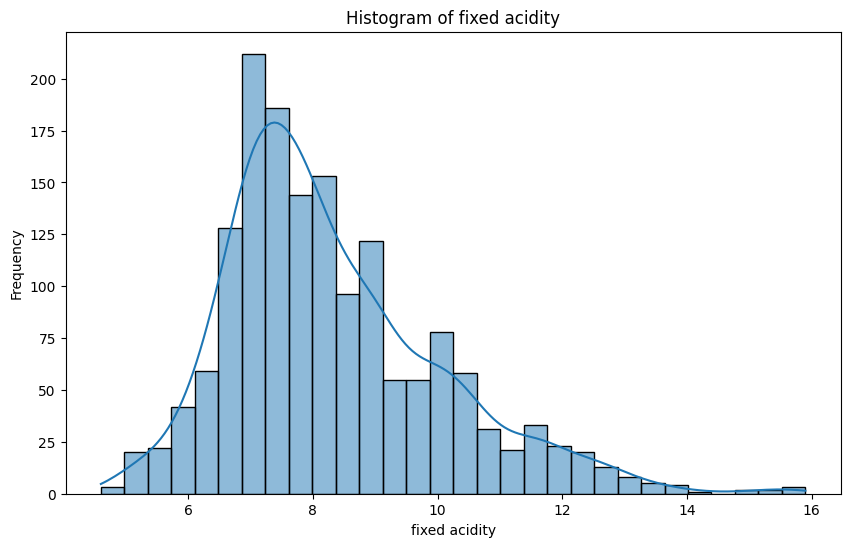

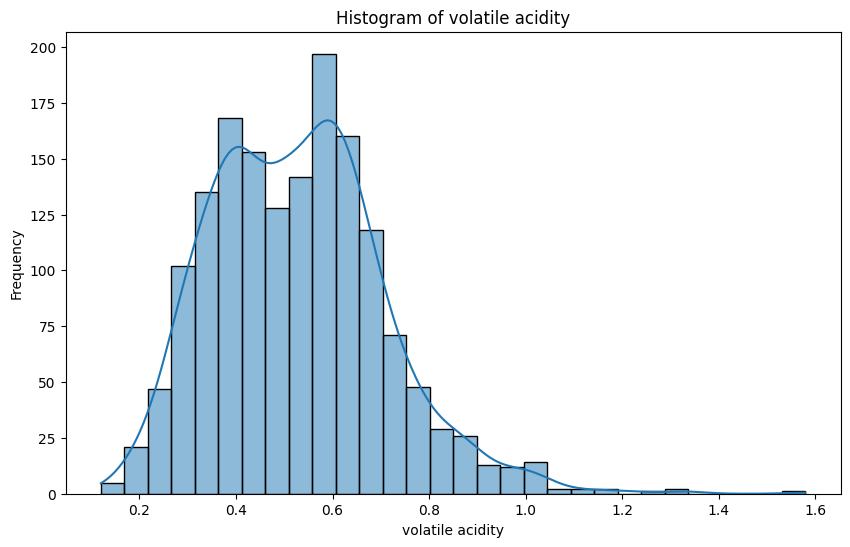

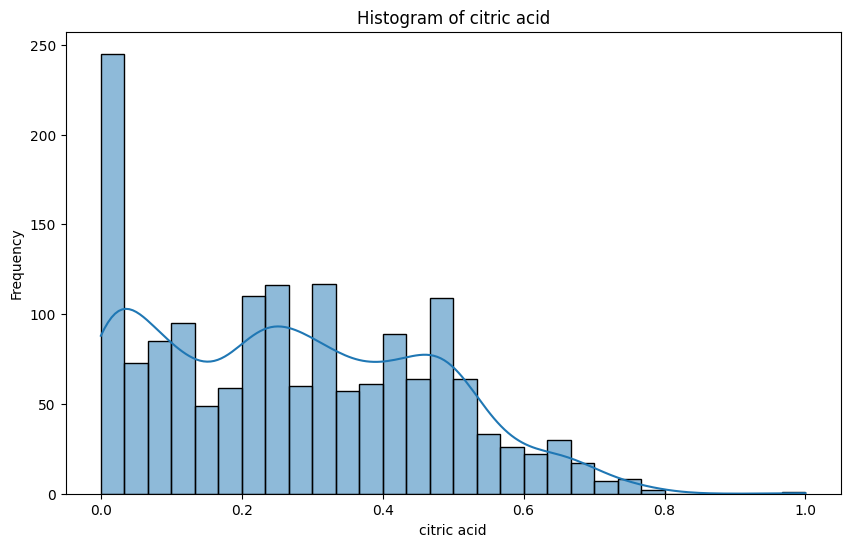

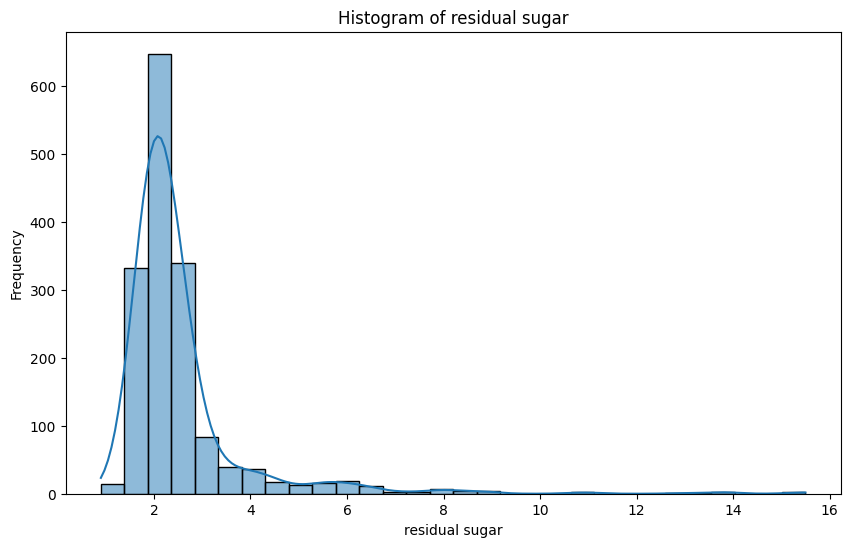

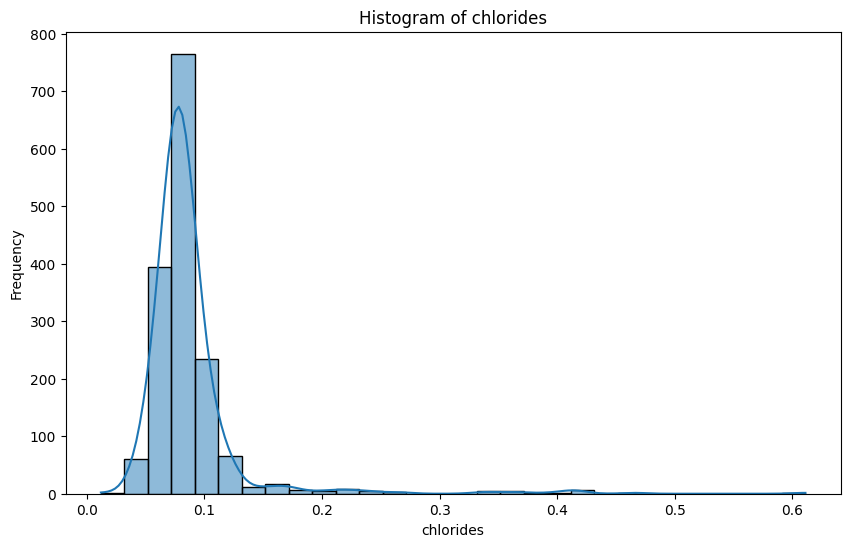

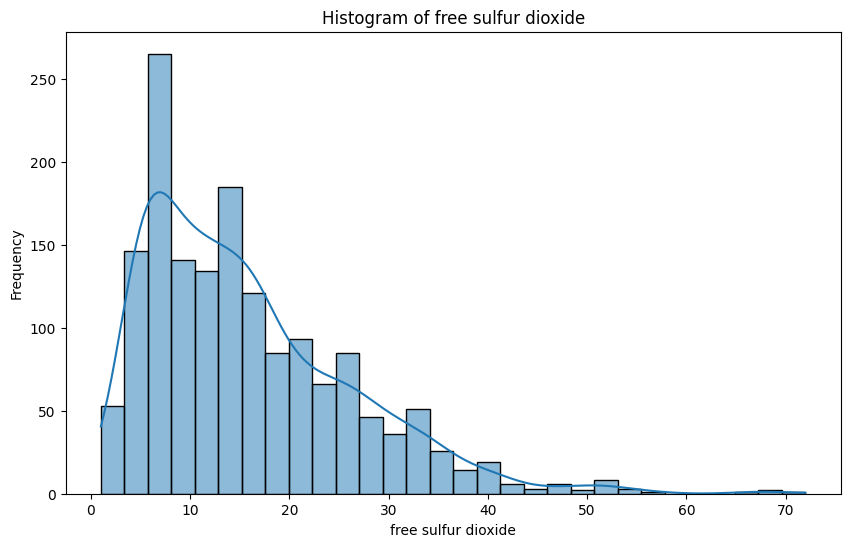

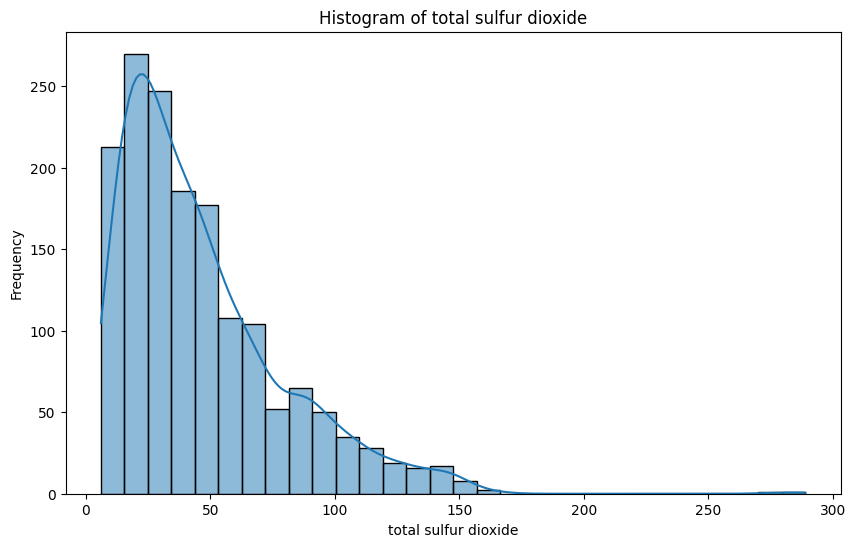

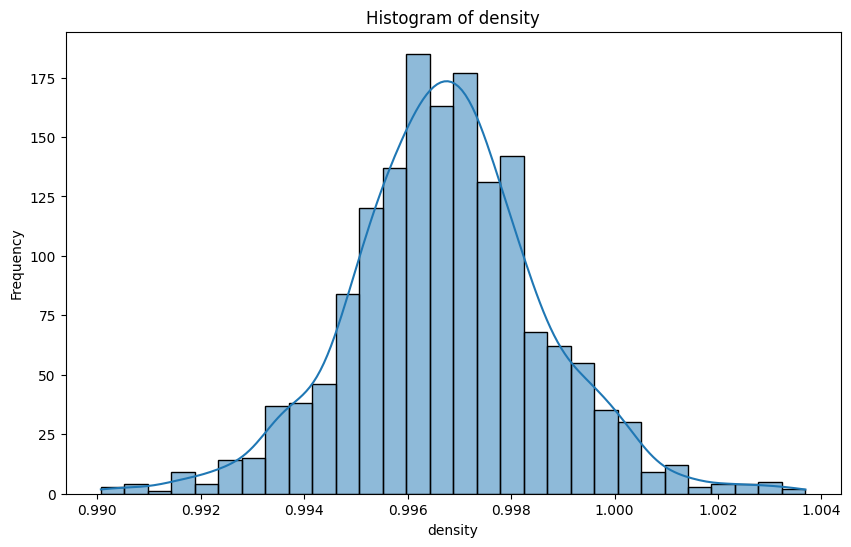

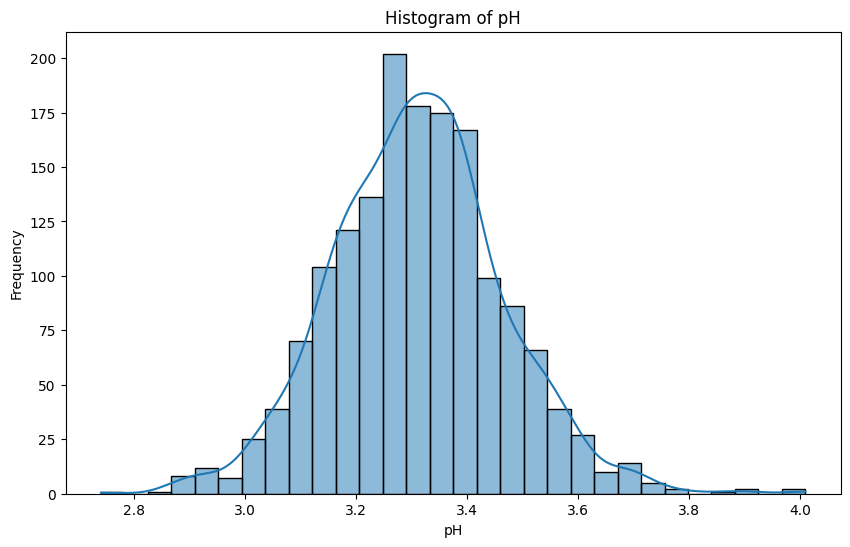

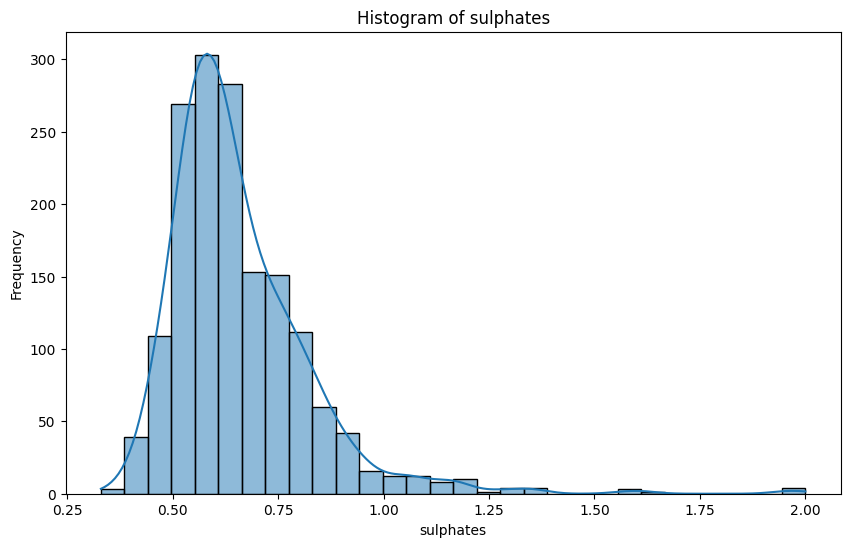

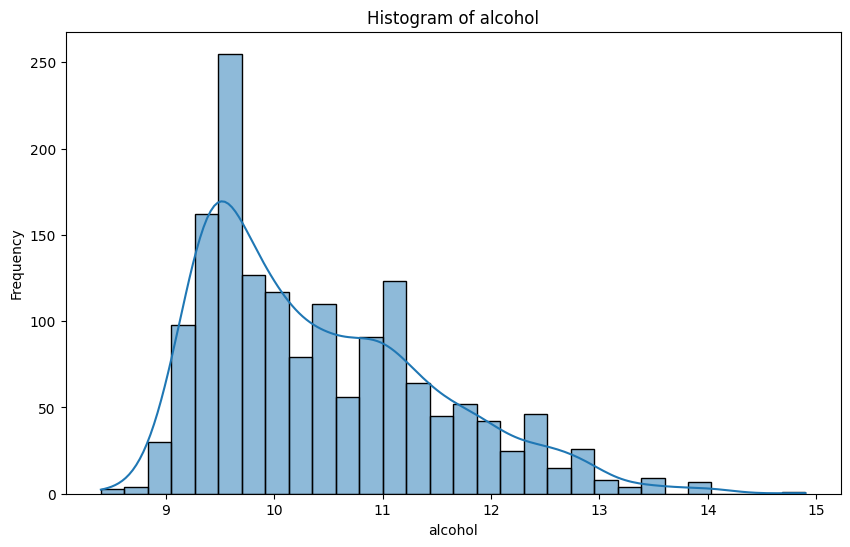

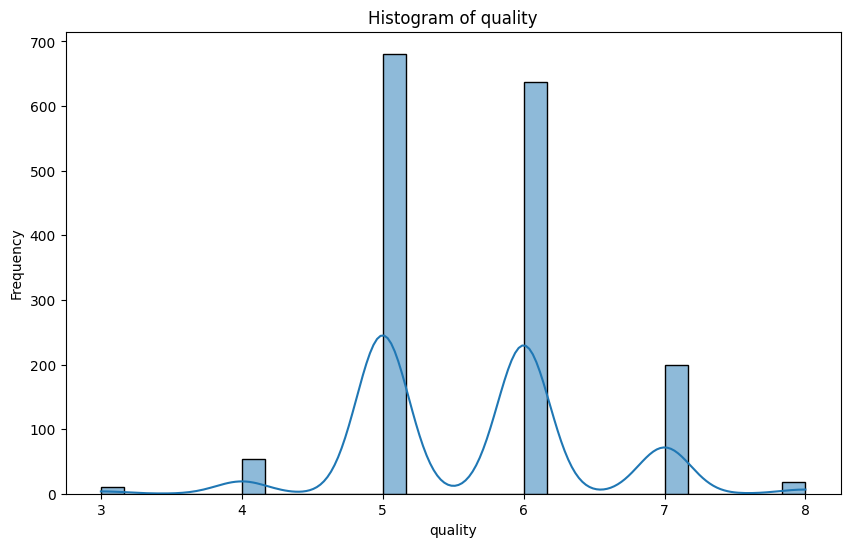

In [39]:
for column in data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], bins=30, kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [40]:
# Normalize the alcohol column
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data['alcohol'] = scaler.fit_transform(data[['alcohol']])
data['sulphates'] = scaler.fit_transform(data[['sulphates']])
data['free sulfur dioxide'] = scaler.fit_transform(data[['free sulfur dioxide']])
data['total sulfur dioxide'] = scaler.fit_transform(data[['total sulfur dioxide']])


In [41]:
data.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [42]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_classifier = DecisionTreeClassifier(criterion='gini')

In [43]:
X = data.drop('quality', axis=1)
y = data['quality']

In [44]:
from sklearn.model_selection import cross_val_score, KFold

k_folds = KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(decision_tree_classifier, X, y, cv=k_folds, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")


Cross-validation scores: [0.56875    0.609375   0.621875   0.665625   0.64263323]
Mean CV accuracy: 0.6217
Standard deviation: 0.0326


---

In [ ]:
class DecisionTree:
    """
    A simple Decision Tree implementation
    Uses Gini impurity as the splitting criterion.
    """
    
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None
    
    def _gini_impurity(self, y):
        """Calculate Gini impurity for a set of labels."""
        if len(y) == 0:
            return 0
        
        # Count occurrences of each class
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        
        # Calculate Gini impurity: 1 - sum(p_i^2)
        return 1 - np.sum(probabilities ** 2)
    
    def _information_gain(self, X_column, y, threshold):
        """Calculate information gain for a potential split."""
        # Split the data
        left_mask = X_column <= threshold
        right_mask = ~left_mask
        
        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return 0
        
        # Calculate weighted average of child impurities
        n = len(y)
        n_left, n_right = np.sum(left_mask), np.sum(right_mask)
        
        left_impurity = self._gini_impurity(y[left_mask])
        right_impurity = self._gini_impurity(y[right_mask])
        
        weighted_impurity = (n_left/n) * left_impurity + (n_right/n) * right_impurity
        
        # Information gain = parent impurity - weighted child impurity
        parent_impurity = self._gini_impurity(y)
        return parent_impurity - weighted_impurity
    
    def _find_best_split(self, X, y):
        """Find the best feature and threshold to split on."""
        best_gain = 0
        best_feature = None
        best_threshold = None
        
        n_features = X.shape[1]
        
        for feature_idx in range(n_features):
            # Get unique values for this feature to use as potential thresholds
            thresholds = np.unique(X[:, feature_idx])
            
            for threshold in thresholds:
                gain = self._information_gain(X[:, feature_idx], y, threshold)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold, best_gain
    
    def _build_tree(self, X, y, depth=0):
        """Recursively build the decision tree."""
        # Base cases for stopping recursion
        n_samples = len(y)
        
        # If all samples have the same class, create leaf node
        if len(np.unique(y)) == 1:
            return {'class': y[0], 'samples': n_samples, 'is_leaf': True}
        
        # If we've reached max depth or minimum samples, create leaf node
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_samples < self.min_samples_split:
            # Return most common class
            most_common_class = np.bincount(y).argmax()
            return {'class': most_common_class, 'samples': n_samples, 'is_leaf': True}
        
        # Find the best split
        best_feature, best_threshold, best_gain = self._find_best_split(X, y)
        
        # If no good split found, create leaf node
        if best_gain == 0:
            most_common_class = np.bincount(y).argmax()
            return {'class': most_common_class, 'samples': n_samples, 'is_leaf': True}
        
        # Split the data
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        # Check minimum samples in leaf
        if np.sum(left_mask) < self.min_samples_leaf or np.sum(right_mask) < self.min_samples_leaf:
            most_common_class = np.bincount(y).argmax()
            return {'class': most_common_class, 'samples': n_samples, 'is_leaf': True}
        
        # Recursively build left and right subtrees
        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)
        
        return {
            'feature': best_feature,
            'threshold': best_threshold,
            'left': left_subtree,
            'right': right_subtree,
            'samples': n_samples,
            'is_leaf': False
        }
    
    def fit(self, X, y):
        """Train the decision tree on the given data."""
        # Convert to numpy arrays if needed
        X = np.array(X) if not isinstance(X, np.ndarray) else X
        y = np.array(y) if not isinstance(y, np.ndarray) else y
        
        # Build the tree
        self.tree = self._build_tree(X, y)
        return self
    
    def _predict_sample(self, x, tree):
        """Predict class for a single sample."""
        if tree['is_leaf']:
            return tree['class']
        
        if x[tree['feature']] <= tree['threshold']:
            return self._predict_sample(x, tree['left'])
        else:
            return self._predict_sample(x, tree['right'])
    
    def predict(self, X):
        """Make predictions for the given samples."""
        if self.tree is None:
            raise ValueError("Tree has not been trained yet. Call fit() first.")
        
        X = np.array(X) if not isinstance(X, np.ndarray) else X
        
        # Handle single sample
        if X.ndim == 1:
            return self._predict_sample(X, self.tree)
        
        # Handle multiple samples
        predictions = []
        for x in X:
            predictions.append(self._predict_sample(x, self.tree))
        
        return np.array(predictions)
    
    def print_tree(self, tree=None, depth=0, prefix="Root: "):
        """Print the decision tree structure."""
        if tree is None:
            tree = self.tree
        
        if tree is None:
            print("Tree has not been trained yet.")
            return
        
        indent = "  " * depth
        
        if tree['is_leaf']:
            print(f"{indent}{prefix}Class = {tree['class']} (samples: {tree['samples']})")
        else:
            print(f"{indent}{prefix}Feature {tree['feature']} <= {tree['threshold']:.3f} (samples: {tree['samples']})")
            self.print_tree(tree['left'], depth + 1, "Left: ")
            self.print_tree(tree['right'], depth + 1, "Right: ")

# Example usage:
import numpy as np

# Create and train our custom decision tree
custom_tree = DecisionTree(max_depth=3, min_samples_split=10, min_samples_leaf=5)
custom_tree.fit(X, y)

# Make predictions
custom_predictions = custom_tree.predict(X)

# Calculate accuracy
custom_accuracy = np.mean(custom_predictions == y)
print(f"\nCustom Decision Tree Accuracy: {custom_accuracy:.4f}")

# Print the tree structure (first few levels)
print("\nDecision Tree Structure:")
custom_tree.print_tree()



Custom Decision Tree Accuracy: 0.5785

Decision Tree Structure:
Root: Feature 10 <= 0.277 (samples: 1599)
  Left: Feature 9 <= 0.144 (samples: 842)
    Left: Feature 6 <= 0.325 (samples: 353)
      Left: Class = 5 (samples: 298)
      Right: Class = 5 (samples: 55)
    Right: Feature 6 <= 0.265 (samples: 489)
      Left: Class = 5 (samples: 397)
      Right: Class = 5 (samples: 92)
  Right: Feature 10 <= 0.477 (samples: 757)
    Left: Feature 1 <= 0.370 (samples: 507)
      Left: Class = 6 (samples: 132)
      Right: Class = 6 (samples: 375)
    Right: Feature 9 <= 0.210 (samples: 250)
      Left: Class = 6 (samples: 136)
      Right: Class = 7 (samples: 114)
